$$
{\Huge \text{ML with Kernels - MVA class of 2020} }\\
{\Large \text{Data challenge}}\\
\textbf{Abdelhakim Benechehab, Ichraq Lemghari}\\ %You should put your name here
\text{Due: 24 March 2020} %You should write the date here.
$$

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
from scipy.spatial import distance_matrix
from scipy import optimize
import cvxopt
from itertools import product
import timeit
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix

# SVM

In [32]:
class SVM:
    # initialization
    def __init__(self,X,y,kernel,reg,gram=False,corres=None,k=6,mms=None,X_test=None):
        self.X = X
        self.y = y
        self.kernel = kernel
        self.reg = reg
        
        self.N = self.X.shape[0]
        
        #self.K = distance_matrix(self.X,self.X)
        #self.K = self.kernel(self.K**2)
        #self.K = normalize(self.K, axis=1, norm='l1')
        
        #if gram is true then use specific functions to compute gram matrix, otherwise use numpy with pairwise conmputations (quite long)
        
        if not gram:
            self.K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, X), 1, X) 
        else:
            # The trick to speed up computation is to stack X and X_test vertically and then compute the gram matrix
            # The first square of the matrix (N * N) is the gram matrix, the rectangle bellow (N_test * N) will be used for prediction
            # Pairwise kernel computations are costly so this turns out to be much more efficient
            
            K_m = gram_mismatch(X, X_test, corres, k, mms)
            
            #K_s = gram_spectrum(X, X_test, corres, k)
            
            threshold = self.N
            self.K = K_m[:threshold,:threshold] #+ K_s[:threshold,:threshold]
            self.K_test = K_m[threshold:,:threshold] #+ K_s[threshold:,:threshold]
        
        self.eps = 1e-5

    def fit(self):
        #To array is used in the case of a sprase matrix
        #K = self.K.toarray() 
        
        #Solving the dual problem using the cvxopt optimization library
        
        P = (1/(2*self.reg))*np.diag(self.y).dot(self.K.dot(np.diag(self.y)))
        q = -np.ones(self.N)
        C = 1/self.N
        
        # Define the quadratic optimization problem
        P = cvxopt.matrix(P, tc='d')
        q = cvxopt.matrix(q)
        
        G_max = np.identity(self.N) * (-1)
        G_min = np.identity(self.N)
        G = cvxopt.matrix(np.vstack((G_max, G_min)))
        h_max = cvxopt.matrix(np.zeros(self.N))
        h_min = cvxopt.matrix(np.ones(self.N) * C)
        h = cvxopt.matrix(np.vstack((h_max, h_min)))
        
        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h)
        
        mu = np.ravel(minimization['x'])
        
        #dual variable
        self.alpha = (1/(2*self.reg))*np.diag(self.y).dot(mu)

    def predict(self, X_test, SV=False):
        
        N_test = X_test.shape[0]
        
        f = np.zeros(N_test)
        
        for i in range(N_test):
            if i % 100 == 0: print("checkpoint: ", i)
            for j in range(self.N):
                if SV:
                    if self.alpha[j] > self.eps:
                        #Use the corresponding part of the gram matrix computed instead of pairwise evaluations of the kernel
                        
                        k = self.K_test[i][j]
                        #k = self.kernel(X_test[i],self.X[j])
                        #k = int(k.toarray())
                        k = float(k)
                        f[i] += self.alpha[j]*k
                else:
                    k = self.K_test[i][j]
                    #k = self.kernel(X_test[i],self.X[j])
                    #k = int(k.toarray())
                    k = float(k)
                    f[i] += self.alpha[j]*k
        
        # Extract predictions
        y_1 = (f > 0).astype("int32")
        
        return y_1
        

# RBF kernel

In [5]:
def RBF_kernel(x1, x2, var):
    diff = x1 - x2
    dist = np.dot(diff,diff)
    return np.exp(-dist / (2 * var))

# Import and format the data

In [4]:
X = pd.read_csv("Xtr0_mat100.csv", header=None, sep=" ")
X = np.array(X)

N = X.shape[0]

y_r = pd.read_csv("Ytr0.csv", index_col=0)
y_r = np.array(y_r).reshape(N)
y = 2*y_r - 1

X_test = pd.read_csv("Xte0_mat100.csv", header=None, sep=" ")
X_test = np.array(X_test)

# Run the algorithm

In [7]:
reg = 0.0001
var = 0.01

algo = SVM(X[:1500],y[:1500],lambda x1, x2: RBF_kernel(x1, x2, var),reg)
algo.fit()

y_hat = algo.predict(X[1500:])
print("\nerror: ", np.sum((y_r[1500:] - y_hat) != 0))

     pcost       dcost       gap    pres   dres
 0: -5.1119e-01 -1.5143e+00  3e+03  5e+01  4e-14
 1: -5.1117e-01 -1.5112e+00  4e+01  8e-01  4e-14
 2: -4.9709e-01 -1.3944e+00  8e+00  1e-01  3e-14
 3: -4.0857e-01 -1.1704e+00  1e+00  1e-02  3e-14
 4: -3.8090e-01 -5.6216e-01  2e-01  5e-18  1e-14
 5: -4.0049e-01 -4.3682e-01  4e-02  4e-18  1e-14
 6: -4.0657e-01 -4.1383e-01  7e-03  4e-18  1e-14
 7: -4.0811e-01 -4.0861e-01  5e-04  5e-18  2e-14
 8: -4.0825e-01 -4.0827e-01  2e-05  5e-18  2e-14
 9: -4.0825e-01 -4.0825e-01  8e-07  5e-18  2e-14
10: -4.0825e-01 -4.0825e-01  4e-08  5e-18  2e-14
Optimal solution found.

error:  205


# Tuning the algorithm: $\lambda$ and $\sigma^2$

In [139]:
regs = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
varss = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

errors = np.zeros((len(regs),len(varss)))

for r in range(len(regs)):
    for v in range(len(varss)):
        reg = regs[r]
        var = varss[v]
        
        print("reg: ", reg, " | var: ", var)
        
        algo = SVM(X[:1500], y[:1500], lambda d: RBF_kernel(d,var), reg)
        algo.fit()
        y_hat = algo.predict(X[1500:])
        
        errors[r,v] = np.sum((y_r[1500:] - y_hat) != 0)
        
        print("error: ", errors[r,v])
     
errors

reg:  1e-05  | var:  1e-05
     pcost       dcost       gap    pres   dres
 0: -1.4920e-02 -1.0149e+00  1e+00  7e-19  2e-16
 1: -1.4920e-02 -2.4925e-02  1e-02  5e-18  7e-17
 2: -1.4920e-02 -1.5020e-02  1e-04  7e-18  2e-17
 3: -1.4920e-02 -1.4921e-02  1e-06  5e-18  5e-17
 4: -1.4920e-02 -1.4920e-02  1e-08  1e-18  1e-16
Optimal solution found.
error:  193.0
reg:  1e-05  | var:  0.0001
     pcost       dcost       gap    pres   dres
 0: -1.4867e-02 -1.0149e+00  1e+00  8e-19  2e-16
 1: -1.4867e-02 -2.4872e-02  1e-02  2e-18  1e-16
 2: -1.4867e-02 -1.4967e-02  1e-04  7e-18  1e-16
 3: -1.4867e-02 -1.4868e-02  1e-06  7e-18  7e-17
 4: -1.4867e-02 -1.4867e-02  1e-08  5e-18  1e-16
Optimal solution found.
error:  186.0
reg:  1e-05  | var:  0.001
     pcost       dcost       gap    pres   dres
 0: -1.3893e-02 -1.0139e+00  3e+03  5e+01  8e-16
 1: -1.3893e-02 -1.0127e+00  3e+01  5e-01  3e-16
 2: -1.3713e-02 -8.9973e-01  1e+00  6e-03  3e-16
 3: -9.5470e-03 -8.4988e-02  8e-02  2e-04  5e-16
 4: -1.3739e

array([[193., 186., 148., 150., 160., 157.],
       [193., 186., 148., 149., 157., 169.],
       [193., 186., 159., 160., 167., 256.],
       [193., 186., 164., 186., 256., 256.],
       [193., 186., 164., 207., 256., 256.],
       [193., 186., 164., 207., 256., 256.]])

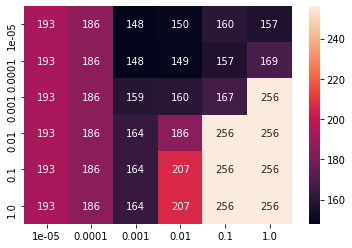

In [140]:
errors = errors.astype("int32")
df = pd.DataFrame(data=errors, index=regs, columns=varss)
sns.heatmap(df, annot=True, fmt="d")

# Select optimal values

In [141]:
reg = 1e-4
var = 0.001

algo = SVM(X,y,lambda d: RBF_kernel(d,var),reg)
algo.fit()

y_hat = algo.predict(X_test)

     pcost       dcost       gap    pres   dres
 0: -1.8359e-01 -1.1839e+00  4e+03  6e+01  8e-16
 1: -1.8359e-01 -1.1833e+00  4e+01  6e-01  3e-16
 2: -1.8350e-01 -1.1323e+00  2e+00  1e-02  3e-16
 3: -1.8229e-01 -3.4074e-01  2e-01  4e-18  3e-16
 4: -1.8352e-01 -1.8917e-01  6e-03  3e-18  2e-16
 5: -1.8356e-01 -1.8377e-01  2e-04  3e-18  2e-16
 6: -1.8357e-01 -1.8357e-01  5e-06  3e-18  2e-16
 7: -1.8357e-01 -1.8357e-01  1e-07  3e-18  2e-16
Optimal solution found.


# Comparing with scikit-learn SVM

In [142]:
from sklearn import svm
svc = svm.SVC(kernel='rbf', verbose=True)
svc.fit(X,y)
t = svc.predict(X_test)
print("\nerror: ", np.sum((((t+1)/2).astype("int32") - y_hat) != 0))

[LibSVM]
error:  166


# Prepare submission data (re-run above code for the three datasets)

In [124]:
rep = y_hat.astype("int32")
df_rep1 = pd.DataFrame(data=np.array([range(1000),rep]).T, columns=["id", "Bound"])
df_rep1

,id,Bound
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
995,995,1
996,996,0
997,997,1
998,998,0


In [136]:
rep = y_hat.astype("int32")
df_rep2 = pd.DataFrame(data=np.array([range(1000,2000),rep]).T, columns=["id", "Bound"])
df_rep2

,id,Bound
0,1000,0
1,1001,1
2,1002,1
3,1003,0
4,1004,1
...,...,...
995,1995,0
996,1996,1
997,1997,0
998,1998,0


In [143]:
rep = y_hat.astype("int32")
df_rep3 = pd.DataFrame(data=np.array([range(2000,3000),rep]).T, columns=["id", "Bound"])
df_rep3

,id,Bound
0,2000,0
1,2001,0
2,2002,1
3,2003,1
4,2004,1
...,...,...
995,2995,1
996,2996,0
997,2997,0
998,2998,0


In [144]:
df_sub = pd.concat([df_rep1,df_rep2,df_rep3])
df_sub

,id,Bound
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
995,2995,1
996,2996,0
997,2997,0
998,2998,0


In [145]:
df_sub.to_csv('submission_svm_tuned.csv', index=False)

# Sequential Data - kspectrum kernel

In [89]:
X = pd.read_csv("Xtr0.csv", sep=",", index_col=0)
X = np.array(X)

N = X.shape[0]

y_r = pd.read_csv("Ytr0.csv", index_col=0)
y_r = np.array(y_r).reshape(N)
y = 2*y_r - 1

X_test = pd.read_csv("Xte0.csv", sep=",", index_col=0)
X_test = np.array(X_test)

* Here we define the corpus ['A','C','G','T']
* We use it to make a dictionnary of correspondances between sequences of length k and indexes. example: AAAAAA -> 0, AAAAAC -> 1 ...
* k and corres are given to the function kspectrum kernel to compute k(xi,xj)
* the output of the kernel function is a sparse object as the arrays used are sparse (only if k is big >8), let's say "r" is the output of the kernel, use "float(r.toarray())" to get its value
* to compute the gram matrix use the function gram_spectrum as it is much faster
* Notice that if k is big (>10) the memory is not enough to store the gram matrix 

In [9]:
corpus = ['A','C','G','T']
corres = dict()
count = 0

for u in product(corpus,repeat=6):
    if count % 500 == 0: print(u)
    s = ''
    for i in range(6):
        s += u[i]
    corres[s] = count
    count += 1
print('GCTAGC: ', corres['GCTAGC'])
print(count)

('A', 'A', 'A', 'A', 'A', 'A')
('A', 'C', 'T', 'T', 'C', 'A')
('A', 'T', 'T', 'G', 'G', 'A')
('C', 'C', 'T', 'C', 'T', 'A')
('C', 'T', 'T', 'C', 'A', 'A')
('G', 'C', 'T', 'A', 'C', 'A')
('G', 'T', 'G', 'T', 'G', 'A')
('T', 'C', 'G', 'G', 'T', 'A')
('T', 'T', 'G', 'G', 'A', 'A')
GCTAGC:  2505
4096


In [36]:
def make_corres(corpus,k):
    '''
    make_corres
    
    Args:
        corpus: the letters that compose the sequences
        k: length of the sequences
        
    Returns:
        corres: dictionnary of correspondances between sequences of length k and indexes
    '''
    corres = dict()
    count = 0
    for u in product(corpus,repeat=k):
        s = ''
        for i in range(k):
            s += u[i]
        corres[s] = count
        count += 1
    return corres
            
def kspectrum_kernel(x1, x2, k, corres):   
    '''
    kspectrum_kernel
    
    Args:
        x1, x2: data points
        corres: dictionnary of correspondances between sequences of length k and indexes
        k: length of the sequences
        
    Returns:
        k(x1,x2): the kernel evaluated at points x1 and x2 (bormalized dot product between feature vectors)
    '''
    sample1 = x1[0]
    sample2 = x2[0]
    
    N = 4**k
    
    #sparse vectors could be used in case of high space complexity, but this is not used systematically as their appending is costly
    feature1 = np.zeros(N)
    feature2 = np.zeros(N)
    
#     feature1 = csr_matrix((1,N), dtype="int32")
#     feature2 = csr_matrix((1,N), dtype="int32")
    
    for i in range(len(sample1)-k+1):
        #extract sub-sequences
        segment1 = sample1[i:i+k]
        segment2 = sample2[i:i+k]
        
        #update feature vectors
        feature1[corres[segment1]] += 1
        feature2[corres[segment2]] += 1
        
    #norrmalize feature vectors
    feature1 = feature1/np.sqrt(feature1.dot(feature1))
    feature2 = feature2/np.sqrt(feature2.dot(feature2))
    
    return feature1.dot(feature2)

def gram_spectrum(X, X_test, corres, k):
    '''
    gram_spectrum
    
    Args:
        X, X_test: training and test data
        corres: dictionnary of correspondances between sequences of length k and indexes
        k: length of the sequences
        
    Returns:
        K: Gram matrix of X and X_test concatenated
    '''
    
    X = np.concatenate((X,X_test),axis=0)
    
    #dimensions
    N = X.shape[0]
    m = len(X[0][0])
    n = 4**k
    
    #Initialize features matrix
    #features = csr_matrix((N,n), dtype="int8")
    features = np.zeros((N,n))
    for sample in range(N):
        for i in range(m-k+1):
            segment = X[sample][0][i:i+k]
            features[sample,corres[segment]] += 1
        #normalization
        features[sample] = features[sample]/np.sqrt(features[sample].dot(features[sample]))
    
    return features.dot(features.T)

# Example (sanity and time check)

In [11]:
x1 = X[0]
x2 = X[1]

start = timeit.default_timer()
corpus = ['A','C','G','T']
k = 7
corres = make_corres(corpus,k)
stop = timeit.default_timer()

print("time to compute corres of size ", k, ": ", stop-start)

start = timeit.default_timer()
r = kspectrum_kernel(x1, x2, k, corres)
stop = timeit.default_timer()
r2 = kspectrum_kernel(X[50], X[75], k, corres)

print("time to compute kernel: ", stop-start)
print("k(0,1): ", float(r))
print("k(50,75): ", float(r2))

start = timeit.default_timer()
K = gram_spectrum(X[:1500], X[1500:], corres, k)
stop = timeit.default_timer()

print("time to compute gram matrix: ", stop-start)
print("K[0,1],K[50,75]: ", K[0,1],K[50,75])

time to compute corres of size  7 :  0.037524599999983366
time to compute kernel:  0.03274659999999585
k(0,1):  0.021052631578947368
k(50,75):  0.0
time to compute gram matrix:  2.038909100000012
K[0,1],K[50,75]:  0.021052631578947368 0.0


# Tuning the parameter $\lambda$

## Dataset 1

reg:  0.001
     pcost       dcost       gap    pres   dres
 0: -1.2953e+00 -2.3189e+00  3e+03  6e+01  1e-15
 1: -1.2940e+00 -2.2939e+00  1e+02  2e+00  6e-16
 2: -1.2136e+00 -2.0831e+00  2e+01  4e-01  6e-16
 3: -8.4557e-01 -1.6221e+00  3e+00  3e-02  1e-15
 4: -6.2699e-01 -1.0334e+00  4e-01  7e-18  1e-15
 5: -6.6737e-01 -7.2238e-01  6e-02  5e-18  6e-16
 6: -6.8110e-01 -6.8991e-01  9e-03  5e-18  4e-16
 7: -6.8417e-01 -6.8497e-01  8e-04  5e-18  4e-16
 8: -6.8448e-01 -6.8459e-01  1e-04  5e-18  4e-16
 9: -6.8453e-01 -6.8453e-01  3e-06  5e-18  4e-16
10: -6.8453e-01 -6.8453e-01  4e-08  5e-18  4e-16
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
error:  158.0
reg:  0.01
     pcost       dcost       gap    pres   dres
 0: -1.2861e+01 -1.2879e+01  5e+03  7e+01  9e-16
 1: -1.2501e+01 -1.1117e+01  5e+02  7e+00  5e-16
 2: -9.1311e+00 -4.9054e+00  6e+01  9e-01  6e-16
 3: -1.9686e+00 -2.0226e+00  7e+00  9e-02  3e-15
 4: -8.4847e-01 -1.6075e+

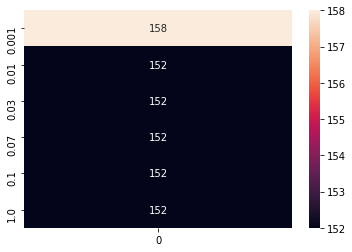

In [114]:
corpus = ['A','C','G','T']
k = 8
corres = make_corres(corpus,k)

regs = np.array([1e-3, 1e-2, 3e-2, 7e-2, 1e-1, 1])

errors = np.zeros(len(regs))

for r in range(len(regs)):
    reg = regs[r]

    print("reg: ", reg)

    algo = SVM(X[:1500], y[:1500], lambda x1, x2: kspectrum_kernel(x1, x2, k, corres), reg, gram=True,corres=corres,k=k,X_test=X[1500:])
    algo.fit()
    y_hat = algo.predict(X[1500:])

    errors[r] = np.sum((y_r[1500:] - y_hat) != 0)

    print("error: ", errors[r])
     
print(errors)

errors = errors.astype("int16")
df = pd.DataFrame(data=errors, index=regs)
sns.heatmap(df, annot=True, fmt="d")
plt.show()

In [115]:
reg = regs[np.argmin(errors)]
print("reg_star: ", reg)
#var = 0.001

algo = SVM(X,y,lambda x1, x2: kspectrum_kernel(x1, x2, k, corres),reg, gram=True, corres=corres, k=k, X_test=X_test)
algo.fit()

y_hat = algo.predict(X_test)

reg_star:  0.01
     pcost       dcost       gap    pres   dres
 0: -1.7369e+01 -1.6846e+01  7e+03  8e+01  1e-15
 1: -1.6804e+01 -1.4337e+01  7e+02  9e+00  6e-16
 2: -1.1994e+01 -5.9281e+00  9e+01  1e+00  7e-16
 3: -2.4685e+00 -2.1077e+00  9e+00  1e-01  3e-15
 4: -8.4546e-01 -1.7322e+00  9e-01  1e-17  3e-15
 5: -9.2312e-01 -9.7270e-01  5e-02  4e-18  1e-15
 6: -9.5063e-01 -9.5256e-01  2e-03  4e-18  7e-16
 7: -9.5176e-01 -9.5178e-01  2e-05  5e-18  6e-16
 8: -9.5177e-01 -9.5177e-01  2e-07  5e-18  6e-16
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
checkpoint:  500
checkpoint:  600
checkpoint:  700
checkpoint:  800
checkpoint:  900


In [116]:
rep = y_hat.astype("int8")
df_rep1 = pd.DataFrame(data=np.array([range(1000),rep]).T, columns=["id", "Bound"])
df_rep1

,id,Bound
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
995,995,1
996,996,0
997,997,0
998,998,0


## Dataset 2

In [117]:
X = pd.read_csv("Xtr1.csv", sep=",", index_col=0)
X = np.array(X)

N = X.shape[0]

y_r = pd.read_csv("Ytr1.csv", index_col=0)
y_r = np.array(y_r).reshape(N)
y = 2*y_r - 1

X_test = pd.read_csv("Xte1.csv", sep=",", index_col=0)
X_test = np.array(X_test)

reg:  0.001
     pcost       dcost       gap    pres   dres
 0: -1.4746e+00 -2.4750e+00  3e+03  6e+01  7e-16
 1: -1.4744e+00 -2.4554e+00  6e+01  1e+00  4e-16
 2: -1.3741e+00 -1.9800e+00  1e+01  2e-01  4e-16
 3: -8.0503e-01 -1.4731e+00  1e+00  5e-03  2e-15
 4: -7.7815e-01 -8.3210e-01  6e-02  1e-04  5e-16
 5: -7.9718e-01 -8.0550e-01  9e-03  2e-05  4e-16
 6: -8.0076e-01 -8.0107e-01  3e-04  3e-07  5e-16
 7: -8.0091e-01 -8.0091e-01  6e-06  5e-09  5e-16
 8: -8.0091e-01 -8.0091e-01  7e-08  5e-11  5e-16
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
error:  202.0
reg:  0.01
     pcost       dcost       gap    pres   dres
 0: -1.4714e+01 -1.4627e+01  4e+03  6e+01  8e-16
 1: -1.4517e+01 -1.2690e+01  3e+02  4e+00  4e-16
 2: -8.8897e+00 -3.8626e+00  3e+01  5e-01  7e-16
 3: -1.5043e+00 -1.8498e+00  3e+00  4e-02  4e-15
 4: -9.1071e-01 -1.3411e+00  4e-01  8e-18  2e-15
 5: -9.7234e-01 -9.8625e-01  1e-02  6e-18  1e-15
 6: -9.7991e-01 -9.8005e-

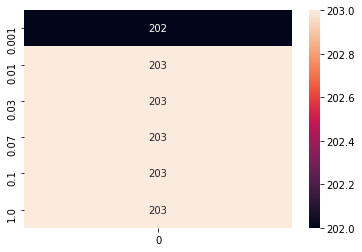

In [118]:
regs = np.array([1e-3, 1e-2, 3e-2, 7e-2, 1e-1, 1])

errors = np.zeros(len(regs))

for r in range(len(regs)):
    reg = regs[r]

    print("reg: ", reg)

    algo = SVM(X[:1500], y[:1500], lambda x1, x2: kspectrum_kernel(x1, x2, k, corres), reg, gram=True, corres=corres, k=k, X_test=X[1500:])
    algo.fit()
    y_hat = algo.predict(X[1500:])

    errors[r] = np.sum((y_r[1500:] - y_hat) != 0)

    print("error: ", errors[r])
     
print(errors)

errors = errors.astype("int16")
df = pd.DataFrame(data=errors, index=regs)
sns.heatmap(df, annot=True, fmt="d")
plt.show()

In [99]:
reg = regs[np.argmin(errors)]
#var = 0.001

algo = SVM(X,y,lambda x1, x2: kspectrum_kernel(x1, x2, k, corres),reg, gram=True, corres=corres, k=k, X_test=X_test)
algo.fit()

y_hat = algo.predict(X_test)

     pcost       dcost       gap    pres   dres
 0: -2.0963e+00 -3.0874e+00  4e+03  6e+01  9e-16
 1: -2.0958e+00 -3.0541e+00  7e+01  1e+00  4e-16
 2: -1.8944e+00 -2.2162e+00  1e+01  2e-01  5e-16
 3: -9.0562e-01 -1.5631e+00  1e+00  1e-02  1e-15
 4: -8.1157e-01 -9.2569e-01  1e-01  4e-18  9e-16
 5: -8.4423e-01 -8.5930e-01  2e-02  4e-18  6e-16
 6: -8.4935e-01 -8.5043e-01  1e-03  5e-18  5e-16
 7: -8.4975e-01 -8.4978e-01  3e-05  5e-18  5e-16
 8: -8.4976e-01 -8.4976e-01  5e-07  5e-18  6e-16
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
checkpoint:  500
checkpoint:  600
checkpoint:  700
checkpoint:  800
checkpoint:  900


In [100]:
rep = y_hat.astype("int8")
df_rep2 = pd.DataFrame(data=np.array([range(1000,2000),rep]).T, columns=["id", "Bound"])
df_rep2

,id,Bound
0,1000,1
1,1001,1
2,1002,1
3,1003,0
4,1004,0
...,...,...
995,1995,0
996,1996,1
997,1997,0
998,1998,0


## Dataset 3

In [119]:
X = pd.read_csv("Xtr2.csv", sep=",", index_col=0)
X = np.array(X)

N = X.shape[0]

y_r = pd.read_csv("Ytr2.csv", index_col=0)
y_r = np.array(y_r).reshape(N)
y = 2*y_r - 1

X_test = pd.read_csv("Xte2.csv", sep=",", index_col=0)
X_test = np.array(X_test)

reg:  1e-06
     pcost       dcost       gap    pres   dres
 0: -1.2955e-03 -1.0013e+00  3e+03  5e+01  9e-16
 1: -1.2955e-03 -1.0000e+00  3e+01  5e-01  6e-16
 2: -1.2768e-03 -8.8114e-01  1e+00  6e-03  7e-16
 3: -3.6477e-04 -8.9866e-02  1e-01  5e-04  9e-16
 4: -5.5215e-04 -2.1909e-02  2e-02  7e-05  8e-16
 5: -1.1888e-03 -2.1213e-03  9e-04  9e-07  1e-15
 6: -1.2625e-03 -1.4193e-03  2e-04  1e-07  5e-16
 7: -1.2693e-03 -1.2977e-03  3e-05  2e-08  4e-16
 8: -1.2707e-03 -1.2741e-03  3e-06  2e-09  5e-16
 9: -1.2709e-03 -1.2711e-03  2e-07  6e-11  5e-16
10: -1.2709e-03 -1.2709e-03  5e-09  1e-12  5e-16
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
error:  152.0
reg:  1e-05
     pcost       dcost       gap    pres   dres
 0: -1.2955e-02 -1.0131e+00  3e+03  5e+01  9e-16
 1: -1.2955e-02 -1.0118e+00  3e+01  6e-01  6e-16
 2: -1.2800e-02 -8.9962e-01  1e+00  8e-03  6e-16
 3: -8.3854e-03 -2.2349e-01  3e-01  1e-03  6e-16
 4: -1.1366e-02 -3.8147e

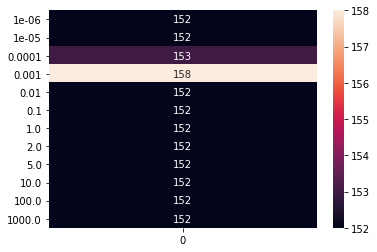

In [121]:
regs = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5, 10, 100, 1000])

errors = np.zeros(len(regs))

for r in range(len(regs)):
    reg = regs[r]

    print("reg: ", reg)

    algo = SVM(X[:1500], y[:1500], lambda x1, x2: kspectrum_kernel(x1, x2, k, corres), reg, gram=True, corres=corres, k=k, X_test=X[1500:])
    algo.fit()
    y_hat = algo.predict(X[1500:])

    errors[r] = np.sum((y_r[1500:] - y_hat) != 0)

    print("error: ", errors[r])
     
print(errors)

errors = errors.astype("int16")
df = pd.DataFrame(data=errors, index=regs)
sns.heatmap(df, annot=True, fmt="d")
plt.show()

In [104]:
reg = regs[np.argmin(errors)]
#var = 0.001

algo = SVM(X,y,lambda x1, x2: kspectrum_kernel(x1, x2, k, corres),reg, gram=True, corres=corres, k=k, X_test=X_test)
algo.fit()

y_hat = algo.predict(X_test)

     pcost       dcost       gap    pres   dres
 0: -5.3931e-01 -1.5461e+00  4e+03  6e+01  1e-15
 1: -5.3922e-01 -1.5432e+00  7e+01  1e+00  8e-16
 2: -5.2914e-01 -1.4817e+00  1e+01  2e-01  8e-16
 3: -4.6580e-01 -1.3122e+00  2e+00  3e-02  7e-16
 4: -4.1299e-01 -7.9132e-01  4e-01  1e-03  6e-16
 5: -4.3515e-01 -4.9332e-01  6e-02  1e-04  4e-16
 6: -4.4689e-01 -4.5671e-01  1e-02  2e-05  3e-16
 7: -4.4949e-01 -4.5086e-01  1e-03  1e-06  3e-16
 8: -4.4989e-01 -4.5006e-01  2e-04  1e-07  3e-16
 9: -4.4995e-01 -4.4995e-01  6e-06  3e-09  3e-16
10: -4.4995e-01 -4.4995e-01  2e-07  4e-11  3e-16
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
checkpoint:  500
checkpoint:  600
checkpoint:  700
checkpoint:  800
checkpoint:  900


In [105]:
rep = y_hat.astype("int8")
df_rep3 = pd.DataFrame(data=np.array([range(2000,3000),rep]).T, columns=["id", "Bound"])
df_rep3

,id,Bound
0,2000,0
1,2001,0
2,2002,1
3,2003,1
4,2004,1
...,...,...
995,2995,1
996,2996,0
997,2997,0
998,2998,0


# Prepare submission data

In [106]:
df_sub = pd.concat([df_rep1,df_rep2,df_rep3])
df_sub

,id,Bound
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
995,2995,1
996,2996,0
997,2997,0
998,2998,0


In [107]:
df_sub.to_csv('submission_kspectrum_8.csv', index=False)

# Mismatch kernel

In [6]:
X = pd.read_csv("Xtr0.csv", sep=",", index_col=0)
X = np.array(X)

N = X.shape[0]

y_r = pd.read_csv("Ytr0.csv", index_col=0)
y_r = np.array(y_r).reshape(N)
y = 2*y_r - 1

X_test = pd.read_csv("Xte0.csv", sep=",", index_col=0)
X_test = np.array(X_test)

* Here we look for all the k-length sequences that match a given sequence up to m mismatches
* we use sparse matrices for big values of k (K>7)
* Computing the mismatches matrix takes relatively long time comparing to the gram matrix

In [35]:
def make_corres(corpus,k):
    '''
    make_corres
    
    Args:
        corpus: the letters that compose the sequences
        k: length of the sequences
        
    Returns:
        corres: dictionnary of correspondances between sequences of length k and indexes
    '''
    corres = dict()
    count = 0
    for u in product(corpus,repeat=k):
        s = ''
        for i in range(k):
            s += u[i]
        corres[s] = count
        count += 1
    return corres

def mismatches(k,m,corres):
    '''
    mismatches
    
    Args:
        k: length of the sequences
        m: number of allowed mismatches
        corres: dictionnary of correspondances between sequences of length k and indexes
        
    Returns:
        mms: matrix of mismatches among all k-length sequences 
    '''
    N = 4**k
    #L = lil_matrix((N,N), dtype="int16")
    L = np.zeros((N,N))
    seqs = list(corres.keys())
    for i in range(N):
        seq1 = seqs[i]
        for j in range(N):
            seq2 = seqs[j]
            mm = 0
            count = 0
            while (mm <= m) and (count <= k-1):
                if seq1[count] != seq2[count]:
                    mm += 1
                count += 1
            if mm <= m:
                L[i,j] = 1
    return L
            
def mismatch_kernel(x1, x2, k, corres, mismatches):          
    '''
    mismatch_kernel
    
    Args:
        x1, x2: data points
        corres: dictionnary of correspondances between sequences of length k and indexes
        k: length of the sequences
        mismatches: matrix of mismatches among all k-length sequences
        
    Returns:
        k(x1,x2): the kernel evaluated at points x1 and x2 (normalized dot product between feature vectors)
    '''
    
    sample1 = x1[0]
    sample2 = x2[0]
    
    N = 4**k
    
    #Initialization
    
    feature1 = np.zeros(N)
    feature2 = np.zeros(N)
    
#     feature1 = csr_matrix((1,N), dtype="int32")
#     feature2 = csr_matrix((1,N), dtype="int32")
    
    for i in range(len(sample1)-k+1):
        segment1 = sample1[i:i+k]
        segment2 = sample2[i:i+k]
        
        feature1 += mismatches[corres[segment1]]
        feature2 += mismatches[corres[segment2]]
        
    #normalization
    feature1 = feature1/np.sqrt(feature1.dot(feature1))
    feature2 = feature2/np.sqrt(feature2.dot(feature2))

    return feature1.dot(feature2)

def gram_mismatch(X, X_test, corres, k, mismatches):
    '''
    gram_spectrum
    
    Args:
        X, X_test: training and test data
        corres: dictionnary of correspondances between sequences of length k and indexes
        k: length of the sequences
        mismatches: matrix of mismatches among all k-length sequences
        
    Returns:
        K: Gram matrix of X and X_test concatenated
    '''
    
    X = np.concatenate((X,X_test),axis=0)
    
    N = X.shape[0]
    m = len(X[0][0])
    n = 4**k
    
    
    #features = csr_matrix((N,n), dtype="int8")
    features = np.zeros((N,n))
    for sample in range(N):
        for i in range(m-k+1):
            segment = X[sample][0][i:i+k]
            features[sample] += mismatches[corres[segment]]
        features[sample] = features[sample]/np.sqrt(features[sample].dot(features[sample]))
        
    #features = csr_matrix(features, shape=(N,n), dtype="int8")
    
    return features.dot(features.T)

# Example (sanity and time check)

In [22]:
x1 = X[0]
x2 = X[1]

corpus = ['A','C','G','T']
k = 7
m = 2

start = timeit.default_timer()
corres = make_corres(corpus,k)
stop = timeit.default_timer()

print("time to compute corres of size ", k, ": ", stop-start)

start = timeit.default_timer()
mms = mismatches(k,m,corres)
stop = timeit.default_timer()

print("time to compute mismatch matrix of size ", k, ": ", stop-start)

start = timeit.default_timer()
r = mismatch_kernel(x1, x2, k, corres, mms)
stop = timeit.default_timer()

r2 = mismatch_kernel(X[50], X[75], k, corres, mms)

print("time to compute kernel: ", stop-start)
print("k(0,1): ", float(r))
print("k(50,75): ", float(r2))

start = timeit.default_timer()
K = gram_mismatch(X, X_test, corres, k, mms)
stop = timeit.default_timer()

print("time to compute gram matrix: ", stop-start)
print("K[0,1],K[50,75]: ", K[0,1],K[50,75])

time to compute corres of size  7 :  0.039476099999774306
time to compute mismatch matrix of size  7 :  205.4502609000001
time to compute kernel:  0.006792900000164082
k(0,1):  0.397746949457418
k(50,75):  0.5328558830204896
time to compute gram matrix:  7.017926800000168
K[0,1],K[50,75]:  0.3964085290201671 0.5319527957430216


# Tuning the parameter $\lambda$

## Dataset 1

reg:  1e-07
     pcost       dcost       gap    pres   dres
 0: -1.2059e-03 -1.0012e+00  3e+03  5e+01  2e-13
 1: -1.2059e-03 -9.9990e-01  3e+01  5e-01  2e-13
 2: -1.1885e-03 -8.8093e-01  1e+00  6e-03  2e-13
 3: -4.0095e-04 -1.0591e-01  1e-01  6e-04  3e-13
 4: -1.8658e-04 -4.0778e-02  5e-02  2e-04  2e-13
 5: -7.8811e-04 -5.0011e-03  4e-03  7e-06  2e-13
 6: -1.0746e-03 -1.4274e-03  4e-04  4e-07  2e-13
 7: -1.1032e-03 -1.1480e-03  4e-05  3e-08  1e-13
 8: -1.1083e-03 -1.1141e-03  6e-06  1e-09  1e-13
 9: -1.1090e-03 -1.1092e-03  2e-07  3e-11  1e-13
10: -1.1090e-03 -1.1090e-03  7e-09  5e-13  1e-13
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
error:  196.0
reg:  1e-06
     pcost       dcost       gap    pres   dres
 0: -1.2059e-02 -1.0121e+00  3e+03  5e+01  2e-13
 1: -1.2059e-02 -1.0109e+00  3e+01  6e-01  2e-13
 2: -1.1921e-02 -8.9804e-01  1e+00  9e-03  2e-13
 3: -8.7692e-03 -3.2094e-01  4e-01  2e-03  2e-13
 4: -8.0484e-03 -8.3008e

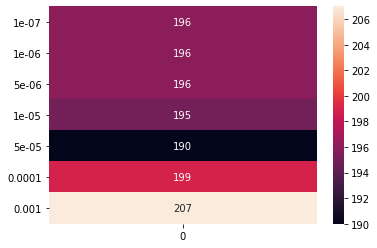

In [24]:
corpus = ['A','C','G','T']
k = 7
m = 2
#corres = make_corres(corpus,k)
#mms = mismatches(k,m,corres)

regs = np.array([1e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 1e-3])

errors = np.zeros(len(regs))

for r in range(len(regs)):
    reg = regs[r]

    print("reg: ", reg)

    algo = SVM(X[:1500], y[:1500], lambda x1, x2: mismatch_kernel(x1, x2, k, corres, mms), reg, gram=True,corres=corres,k=k, mms=mms, X_test=X[1500:])
    algo.fit()
    y_hat = algo.predict(X[1500:])

    errors[r] = np.sum((y_r[1500:] - y_hat) != 0)

    print("error: ", errors[r])
     
print(errors)

errors = errors.astype("int16")
df = pd.DataFrame(data=errors, index=regs)
sns.heatmap(df, annot=True, fmt="d")
plt.show()

In [56]:
reg = regs[np.argmin(errors)]
print("reg_star: ", reg)
#var = 0.001

algo = SVM(X, y, lambda x1, x2: mismatch_kernel(x1, x2, k, corres, mms), reg, gram=True,corres=corres,k=k, mms=mms,X_test=X_test)
algo.fit()

y_hat = algo.predict(X_test)

reg_star:  0.0001
     pcost       dcost       gap    pres   dres
 0: -2.6395e-01 -1.2656e+00  4e+03  6e+01  4e-15
 1: -2.6394e-01 -1.2647e+00  5e+01  7e-01  4e-15
 2: -2.6137e-01 -1.2054e+00  5e+00  7e-02  4e-15
 3: -2.4052e-01 -9.8115e-01  1e+00  1e-02  3e-15
 4: -2.3318e-01 -3.9415e-01  2e-01  4e-05  2e-15
 5: -2.4096e-01 -2.6834e-01  3e-02  5e-06  2e-15
 6: -2.4310e-01 -2.4627e-01  3e-03  6e-08  2e-15
 7: -2.4341e-01 -2.4388e-01  5e-04  3e-18  3e-15
 8: -2.4345e-01 -2.4348e-01  3e-05  4e-18  3e-15
 9: -2.4345e-01 -2.4345e-01  6e-07  4e-18  3e-15
10: -2.4345e-01 -2.4345e-01  2e-08  4e-18  3e-15
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
checkpoint:  500
checkpoint:  600
checkpoint:  700
checkpoint:  800
checkpoint:  900


In [57]:
rep = y_hat.astype("int8")
df_rep1 = pd.DataFrame(data=np.array([range(1000),rep]).T, columns=["id", "Bound"])
df_rep1

,id,Bound
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
995,995,0
996,996,1
997,997,1
998,998,1


## Dataset 2

In [26]:
X = pd.read_csv("Xtr1.csv", sep=",", index_col=0)
X = np.array(X)

N = X.shape[0]

y_r = pd.read_csv("Ytr1.csv", index_col=0)
y_r = np.array(y_r).reshape(N)
y = 2*y_r - 1

X_test = pd.read_csv("Xte1.csv", sep=",", index_col=0)
X_test = np.array(X_test)

reg:  1e-06
     pcost       dcost       gap    pres   dres
 0: -1.1025e-02 -1.0111e+00  3e+03  5e+01  2e-13
 1: -1.1025e-02 -1.0098e+00  3e+01  5e-01  1e-13
 2: -1.0892e-02 -8.9598e-01  1e+00  7e-03  1e-13
 3: -8.0318e-03 -2.5904e-01  3e-01  2e-03  2e-13
 4: -8.0815e-03 -5.8151e-02  5e-02  2e-04  2e-13
 5: -1.0105e-02 -1.2513e-02  2e-03  3e-06  1e-13
 6: -1.0346e-02 -1.0655e-02  3e-04  3e-07  1e-13
 7: -1.0390e-02 -1.0416e-02  3e-05  1e-08  1e-13
 8: -1.0395e-02 -1.0396e-02  1e-06  4e-10  1e-13
 9: -1.0395e-02 -1.0395e-02  4e-08  8e-12  1e-13
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
error:  202.0
reg:  5e-06
     pcost       dcost       gap    pres   dres
 0: -5.5123e-02 -1.0554e+00  3e+03  5e+01  1e-13
 1: -5.5123e-02 -1.0543e+00  3e+01  6e-01  1e-13
 2: -5.4836e-02 -9.5785e-01  2e+00  1e-02  1e-13
 3: -4.8200e-02 -4.6122e-01  5e-01  4e-03  1e-13
 4: -4.7648e-02 -9.2971e-02  5e-02  4e-18  1e-13
 5: -5.1377e-02 -5.5803e

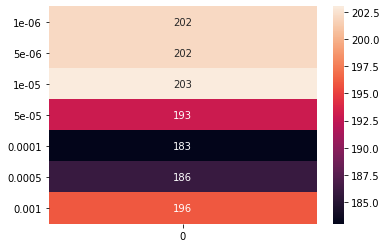

In [28]:
corpus = ['A','C','G','T']
k = 7
m = 2
# corres = make_corres(corpus,k)
# mms = mismatches(k,m,corres)

regs = np.array([1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3])

errors = np.zeros(len(regs))

for r in range(len(regs)):
    reg = regs[r]

    print("reg: ", reg)

    algo = SVM(X[:1500], y[:1500], lambda x1, x2: mismatch_kernel(x1, x2, k, corres, mms), reg, gram=True,corres=corres,k=k, mms=mms,X_test=X[1500:])
    algo.fit()
    y_hat = algo.predict(X[1500:])

    errors[r] = np.sum((y_r[1500:] - y_hat) != 0)

    print("error: ", errors[r])
     
print(errors)

errors = errors.astype("int16")
df = pd.DataFrame(data=errors, index=regs)
sns.heatmap(df, annot=True, fmt="d")
plt.show()

In [60]:
reg = regs[np.argmin(errors)]
print("reg_star: ", reg)
#var = 0.001

algo = SVM(X, y, lambda x1, x2: mismatch_kernel(x1, x2, k, corres, mms), reg, gram=True,corres=corres,k=k, mms=mms,X_test=X_test)
algo.fit()

y_hat = algo.predict(X_test)

reg_star:  0.0001
     pcost       dcost       gap    pres   dres
 0: -2.4313e-01 -1.2448e+00  4e+03  6e+01  2e-15
 1: -2.4313e-01 -1.2441e+00  5e+01  7e-01  3e-15
 2: -2.4197e-01 -1.1929e+00  5e+00  7e-02  2e-15
 3: -2.3010e-01 -9.2323e-01  1e+00  8e-03  2e-15
 4: -2.2887e-01 -3.2108e-01  9e-02  4e-18  2e-15
 5: -2.3492e-01 -2.4652e-01  1e-02  4e-18  2e-15
 6: -2.3596e-01 -2.3719e-01  1e-03  4e-18  2e-15
 7: -2.3610e-01 -2.3618e-01  8e-05  3e-18  2e-15
 8: -2.3611e-01 -2.3611e-01  3e-06  3e-18  2e-15
 9: -2.3611e-01 -2.3611e-01  1e-07  4e-18  2e-15
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
checkpoint:  500
checkpoint:  600
checkpoint:  700
checkpoint:  800
checkpoint:  900


In [61]:
rep = y_hat.astype("int8")
df_rep2 = pd.DataFrame(data=np.array([range(1000,2000),rep]).T, columns=["id", "Bound"])
df_rep2

,id,Bound
0,1000,1
1,1001,1
2,1002,1
3,1003,0
4,1004,0
...,...,...
995,1995,0
996,1996,0
997,1997,0
998,1998,0


## Dataset 3

In [29]:
X = pd.read_csv("Xtr2.csv", sep=",", index_col=0)
X = np.array(X)

N = X.shape[0]

y_r = pd.read_csv("Ytr2.csv", index_col=0)
y_r = np.array(y_r).reshape(N)
y = 2*y_r - 1

X_test = pd.read_csv("Xte2.csv", sep=",", index_col=0)
X_test = np.array(X_test)

reg:  1e-07
     pcost       dcost       gap    pres   dres
 0: -9.2596e-04 -1.0009e+00  3e+03  5e+01  2e-13
 1: -9.2596e-04 -9.9962e-01  3e+01  5e-01  2e-13
 2: -9.1267e-04 -8.8056e-01  1e+00  6e-03  2e-13
 3: -3.2134e-04 -1.1492e-01  1e-01  6e-04  2e-13
 4: -3.1543e-04 -4.2196e-02  5e-02  2e-04  2e-13
 5: -4.5567e-04 -1.1792e-02  1e-02  4e-05  2e-13
 6: -7.2447e-04 -1.1997e-03  5e-04  4e-07  1e-13
 7: -7.7896e-04 -8.6760e-04  9e-05  6e-08  1e-13
 8: -7.9149e-04 -8.0696e-04  2e-05  8e-09  1e-13
 9: -7.9431e-04 -7.9532e-04  1e-06  2e-10  1e-13
10: -7.9453e-04 -7.9460e-04  7e-08  1e-11  1e-13
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
error:  140.0
reg:  1e-06
     pcost       dcost       gap    pres   dres
 0: -9.2596e-03 -1.0094e+00  3e+03  5e+01  2e-13
 1: -9.2596e-03 -1.0081e+00  3e+01  6e-01  1e-13
 2: -9.1554e-03 -8.9427e-01  1e+00  1e-02  1e-13
 3: -6.6007e-03 -3.2262e-01  4e-01  3e-03  2e-13
 4: -4.2686e-03 -1.3076e

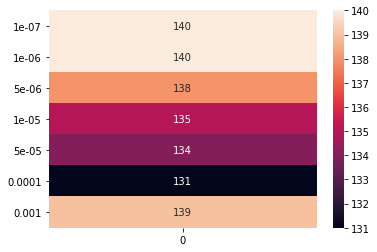

In [30]:
corpus = ['A','C','G','T']
k = 7
m = 2
# corres = make_corres(corpus,k)
# mms = mismatches(k,m,corres)
    
regs = np.array([1e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 1e-3])

errors = np.zeros(len(regs))

for r in range(len(regs)):
    reg = regs[r]

    print("reg: ", reg)

    algo = SVM(X[:1500], y[:1500], lambda x1, x2: mismatch_kernel(x1, x2, k, corres, mms), reg, gram=True,corres=corres,k=k, mms=mms, X_test=X[1500:])
    algo.fit()
    y_hat = algo.predict(X[1500:])

    errors[r] = np.sum((y_r[1500:] - y_hat) != 0)

    print("error: ", errors[r])
     
print(errors)

errors = errors.astype("int16")
df = pd.DataFrame(data=errors, index=regs)
sns.heatmap(df, annot=True, fmt="d")
plt.show()

In [64]:
reg = regs[np.argmin(errors)]
print("reg_star: ", reg)
#var = 0.001

algo = SVM(X, y, lambda x1, x2: mismatch_kernel(x1, x2, k, corres, mms), reg, gram=True,corres=corres,k=k, mms=mms, X_test=X_test)
algo.fit()

y_hat = algo.predict(X_test)

reg_star:  1e-07
     pcost       dcost       gap    pres   dres
 0: -2.0645e-04 -1.0002e+00  4e+03  6e+01  4e-15
 1: -2.0645e-04 -9.9922e-01  4e+01  6e-01  4e-15
 2: -2.0466e-04 -9.0738e-01  1e+00  6e-03  5e-15
 3: -2.5946e-05 -5.2672e-02  6e-02  2e-04  6e-15
 4: -3.9684e-05 -1.2795e-02  1e-02  4e-05  6e-15
 5: -8.4785e-05 -3.7942e-03  4e-03  8e-06  5e-15
 6: -1.7855e-04 -3.1236e-04  1e-04  8e-08  4e-15
 7: -1.9158e-04 -2.1474e-04  2e-05  1e-08  3e-15
 8: -1.9361e-04 -1.9939e-04  6e-06  2e-09  3e-15
 9: -1.9419e-04 -1.9514e-04  1e-06  2e-10  3e-15
10: -1.9430e-04 -1.9438e-04  8e-08  1e-11  3e-15
Optimal solution found.
checkpoint:  0
checkpoint:  100
checkpoint:  200
checkpoint:  300
checkpoint:  400
checkpoint:  500
checkpoint:  600
checkpoint:  700
checkpoint:  800
checkpoint:  900


In [65]:
rep = y_hat.astype("int8")
df_rep3 = pd.DataFrame(data=np.array([range(2000,3000),rep]).T, columns=["id", "Bound"])
df_rep3

,id,Bound
0,2000,0
1,2001,0
2,2002,0
3,2003,1
4,2004,0
...,...,...
995,2995,1
996,2996,0
997,2997,0
998,2998,0


# Preparing submission data

In [66]:
df_sub = pd.concat([df_rep1,df_rep2,df_rep3])
df_sub

,id,Bound
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
995,2995,1
996,2996,0
997,2997,0
998,2998,0


In [67]:
df_sub.to_csv('submission_mismatch_8_1.csv', index=False)

### Thanks for reading!